# Handling Missing Data: Strategies and Best Practices

This notebook explores different techniques for handling missing data in datasets. We'll examine when to use each approach and understand the trade-offs involved in different strategies.

## Import libraries and set up environment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

# Set random seed for reproducibility
np.random.seed(42)

## Create sample datasets with different missing data patterns

We'll create two datasets:
1. A sales dataset with various missing patterns
2. A time series dataset to demonstrate forward/backward fill

In [3]:
# Create a sales dataset with missing values
n_samples = 200

# Generate base data
sales_data = {
    'product_id': np.random.choice(['A', 'B', 'C', 'D'], n_samples),
    'store_region': np.random.choice(['North', 'South', 'East', 'West'], n_samples),
    'units_sold': np.random.randint(1, 100, n_samples),
    'unit_price': np.random.uniform(10, 100, n_samples),
    'customer_age': np.random.randint(18, 70, n_samples),
    'customer_income': np.random.normal(50000, 20000, n_samples),
    'satisfaction_score': np.random.randint(1, 6, n_samples),
    'return_customer': np.random.choice(['Yes', 'No'], n_samples)
}

df_sales = pd.DataFrame(sales_data)

# Introduce missing values with different patterns
# MCAR (Missing Completely At Random) - 10% missing
mcar_mask = np.random.random(n_samples) < 0.1
df_sales.loc[mcar_mask, 'units_sold'] = np.nan

# MAR (Missing At Random) - income missing more often for younger customers
mar_mask = (df_sales['customer_age'] < 25) & (np.random.random(n_samples) < 0.3)
df_sales.loc[mar_mask, 'customer_income'] = np.nan

# MNAR (Missing Not At Random) - low satisfaction scores often not reported
mnar_mask = (df_sales['satisfaction_score'] <= 2) & (np.random.random(n_samples) < 0.4)
df_sales.loc[mnar_mask, 'satisfaction_score'] = np.nan

# Add some missing prices (15% missing)
price_mask = np.random.random(n_samples) < 0.15
df_sales.loc[price_mask, 'unit_price'] = np.nan

# Round values for cleaner display
df_sales['unit_price'] = df_sales['unit_price'].round(2)
df_sales['customer_income'] = df_sales['customer_income'].round(0)

print(f"Sales dataset shape: {df_sales.shape}")
print("\nMissing value counts:")
print(df_sales.isnull().sum())
df_sales.head(10)

Sales dataset shape: (200, 8)

Missing value counts:
product_id             0
store_region           0
units_sold            25
unit_price            31
customer_age           0
customer_income        7
satisfaction_score    34
return_customer        0
dtype: int64


,product_id,store_region,units_sold,unit_price,customer_age,customer_income,satisfaction_score,return_customer
0,C,East,24.0,20.45,40,42239.0,NaN,No
1,D,West,75.0,NaN,54,36632.0,2.0,No
2,A,East,72.0,13.67,54,77915.0,1.0,No
3,C,North,36.0,86.99,27,23807.0,5.0,Yes
4,C,West,38.0,NaN,27,11724.0,3.0,Yes
5,D,North,84.0,52.68,36,68826.0,5.0,Yes
6,A,West,99.0,18.81,34,50554.0,3.0,Yes
7,A,West,89.0,54.25,38,52547.0,4.0,No
8,C,South,99.0,52.61,31,42772.0,5.0,No
9,B,North,25.0,25.59,26,45230.0,4.0,No


In [4]:
# Create a time series dataset for demonstrating forward/backward fill
dates = pd.date_range('2024-01-01', periods=30, freq='D')
temperature_data = {
    'date': dates,
    'temperature': np.random.normal(20, 5, 30),
    'humidity': np.random.uniform(40, 80, 30)
}

df_timeseries = pd.DataFrame(temperature_data)

# Introduce some missing values
missing_indices = [5, 6, 12, 18, 19, 25]
df_timeseries.loc[missing_indices, 'temperature'] = np.nan
df_timeseries.loc[[3, 8, 15, 22], 'humidity'] = np.nan

# Round for cleaner display
df_timeseries['temperature'] = df_timeseries['temperature'].round(1)
df_timeseries['humidity'] = df_timeseries['humidity'].round(1)

print("Time series dataset:")
df_timeseries.head(10)

Time series dataset:


,date,temperature,humidity
0,2024-01-01,16.4,57.5
1,2024-01-02,10.7,69.2
2,2024-01-03,19.6,70.6
3,2024-01-04,19.4,NaN
4,2024-01-05,27.6,64.4
5,2024-01-06,NaN,45.4
6,2024-01-07,NaN,70.1
7,2024-01-08,29.3,66.3
8,2024-01-09,26.1,NaN
9,2024-01-10,22.9,42.8


## Section 1: Understanding Your Missing Data

Before handling missing data, it's crucial to understand the pattern and extent of missingness.

In [5]:
def analyze_missing_data(df):
    """Analyze missing data patterns in a dataframe"""
    missing_df = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
        'Data_Type': df.dtypes
    })
    
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
    return missing_df

missing_analysis = analyze_missing_data(df_sales)
print("Missing Data Analysis:")
print(missing_analysis)

Missing Data Analysis:
                                Column  Missing_Count  Missing_Percentage  \
satisfaction_score  satisfaction_score             34                17.0   
unit_price                  unit_price             31                15.5   
units_sold                  units_sold             25                12.5   
customer_income        customer_income              7                 3.5   

                   Data_Type  
satisfaction_score   float64  
unit_price           float64  
units_sold           float64  
customer_income      float64  


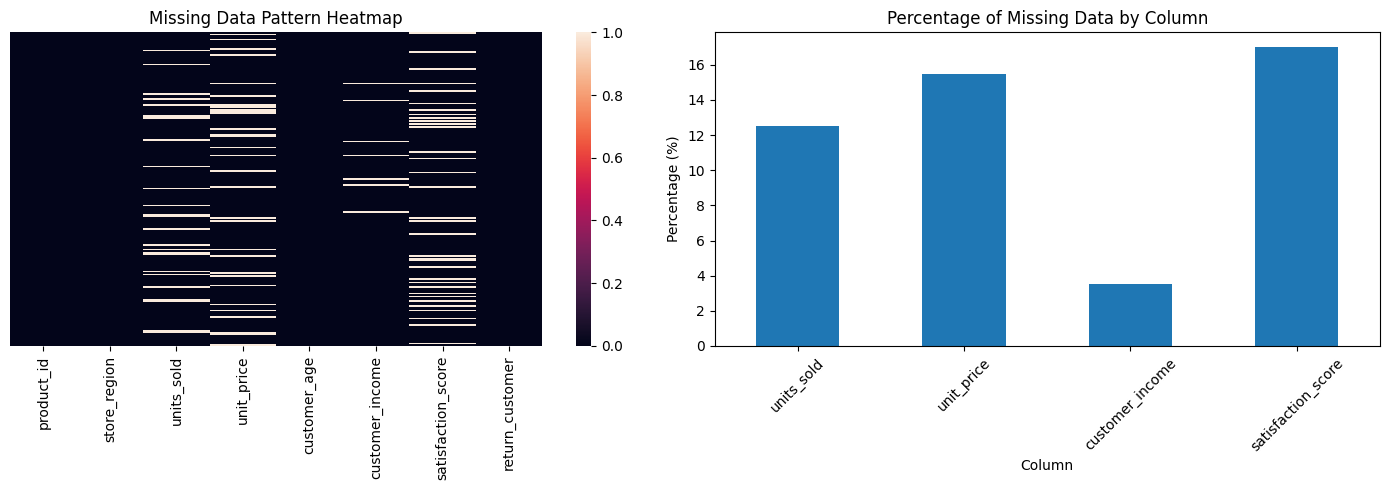

In [6]:
# Visualize missing data patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Missing data heatmap
sns.heatmap(df_sales.isnull(), cbar=True, ax=axes[0], yticklabels=False)
axes[0].set_title('Missing Data Pattern Heatmap')

# Bar plot of missing percentages
missing_pct = (df_sales.isnull().sum() / len(df_sales)) * 100
missing_pct[missing_pct > 0].plot(kind='bar', ax=axes[1])
axes[1].set_title('Percentage of Missing Data by Column')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xlabel('Column')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Section 2: Deletion Methods

Sometimes the simplest approach is to remove missing data. Let's explore when this is appropriate.

In [7]:
# Create a copy for deletion experiments
df_deletion = df_sales.copy()

print(f"Original dataset shape: {df_deletion.shape}")
print(f"Total missing values: {df_deletion.isnull().sum().sum()}")

Original dataset shape: (200, 8)
Total missing values: 97


In [8]:
# Method 1: Drop rows with any missing values
df_dropna_any = df_deletion.dropna()
print(f"After dropping rows with ANY missing values:")
print(f"  Shape: {df_dropna_any.shape}")
print(f"  Rows removed: {len(df_deletion) - len(df_dropna_any)} ({((len(df_deletion) - len(df_dropna_any))/len(df_deletion)*100):.1f}%)")
print(f"  Data retained: {(len(df_dropna_any)/len(df_deletion)*100):.1f}%")

After dropping rows with ANY missing values:
  Shape: (118, 8)
  Rows removed: 82 (41.0%)
  Data retained: 59.0%


In [9]:
# Method 2: Drop rows where all values are missing (if any)
df_dropna_all = df_deletion.dropna(how='all')
print(f"After dropping rows with ALL missing values:")
print(f"  Shape: {df_dropna_all.shape}")
print(f"  Rows removed: {len(df_deletion) - len(df_dropna_all)}")

After dropping rows with ALL missing values:
  Shape: (200, 8)
  Rows removed: 0


In [10]:
# Method 3: Drop rows with missing values in specific columns
critical_columns = ['product_id', 'units_sold']
df_dropna_subset = df_deletion.dropna(subset=critical_columns)
print(f"After dropping rows with missing values in {critical_columns}:")
print(f"  Shape: {df_dropna_subset.shape}")
print(f"  Rows removed: {len(df_deletion) - len(df_dropna_subset)}")

After dropping rows with missing values in ['product_id', 'units_sold']:
  Shape: (175, 8)
  Rows removed: 25


In [11]:
# Method 4: Drop columns with high percentage of missing values
threshold_pct = 30  # Drop columns with >30% missing
missing_pct = (df_deletion.isnull().sum() / len(df_deletion)) * 100
cols_to_keep = missing_pct[missing_pct <= threshold_pct].index
df_drop_cols = df_deletion[cols_to_keep]

print(f"After dropping columns with >{threshold_pct}% missing values:")
print(f"  Shape: {df_drop_cols.shape}")
print(f"  Columns removed: {set(df_deletion.columns) - set(df_drop_cols.columns)}")

After dropping columns with >30% missing values:
  Shape: (200, 8)
  Columns removed: set()


### Exercise 1: Deletion Strategy
Write a function that implements a smart deletion strategy: drop columns with >50% missing data, then drop rows with >3 missing values.

In [12]:
def smart_deletion(df, col_threshold_pct=50, row_threshold_count=3):
    """
    Implement a two-step deletion strategy:
    1. Drop columns with more than col_threshold_pct% missing
    2. Drop rows with more than row_threshold_count missing values
    """
    # Your code here
    pass

# Test your function
# df_smart = smart_deletion(df_sales.copy())
# print(f"Result shape: {df_smart.shape}")

## Section 3: Simple Imputation Methods

Imputation fills in missing values with estimates. Let's explore basic imputation strategies.

In [13]:
# Create a copy for imputation
df_impute = df_sales.copy()

# Separate numerical and categorical columns
numerical_cols = df_impute.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_impute.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

Numerical columns: ['units_sold', 'unit_price', 'customer_age', 'customer_income', 'satisfaction_score']
Categorical columns: ['product_id', 'store_region', 'return_customer']


In [14]:
# Method 1: Mean imputation for numerical columns
df_mean_impute = df_impute.copy()
for col in numerical_cols:
    mean_value = df_mean_impute[col].mean()
    df_mean_impute[col].fillna(mean_value, inplace=True)
    print(f"{col}: Filled with mean = {mean_value:.2f}")

print(f"\nMissing values after mean imputation: {df_mean_impute[numerical_cols].isnull().sum().sum()}")

units_sold: Filled with mean = 49.69
unit_price: Filled with mean = 56.00
customer_age: Filled with mean = 43.74
customer_income: Filled with mean = 48462.69
satisfaction_score: Filled with mean = 3.19

Missing values after mean imputation: 0


/var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/ipykernel_45242/2465604642.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_mean_impute[col].fillna(mean_value, inplace=True)


In [15]:
# Method 2: Median imputation (more robust to outliers)
df_median_impute = df_impute.copy()
for col in numerical_cols:
    median_value = df_median_impute[col].median()
    df_median_impute[col].fillna(median_value, inplace=True)
    print(f"{col}: Filled with median = {median_value:.2f}")

units_sold: Filled with median = 48.00
unit_price: Filled with median = 57.08
customer_age: Filled with median = 43.00
customer_income: Filled with median = 47703.00
satisfaction_score: Filled with median = 3.00


/var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/ipykernel_45242/2343783885.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_median_impute[col].fillna(median_value, inplace=True)
/var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/ipykernel_45242/2343783885.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

In [16]:
# Method 3: Mode imputation for categorical columns
df_mode_impute = df_impute.copy()
for col in categorical_cols:
    if df_mode_impute[col].isnull().any():
        mode_value = df_mode_impute[col].mode()[0]
        df_mode_impute[col].fillna(mode_value, inplace=True)
        print(f"{col}: Filled with mode = {mode_value}")

In [17]:
# Method 4: Using scikit-learn's SimpleImputer
from sklearn.impute import SimpleImputer

# For numerical columns
num_imputer = SimpleImputer(strategy='mean')
df_sklearn_impute = df_impute.copy()
df_sklearn_impute[numerical_cols] = num_imputer.fit_transform(df_sklearn_impute[numerical_cols])

# For categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df_sklearn_impute[categorical_cols] = cat_imputer.fit_transform(df_sklearn_impute[categorical_cols])

print("Missing values after sklearn imputation:")
print(df_sklearn_impute.isnull().sum())

Missing values after sklearn imputation:
product_id            0
store_region          0
units_sold            0
unit_price            0
customer_age          0
customer_income       0
satisfaction_score    0
return_customer       0
dtype: int64


## Section 4: Advanced Imputation Methods

More sophisticated methods can provide better estimates by considering relationships between variables.

/var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/ipykernel_45242/4286484817.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ts_ffill['temperature'].fillna(method='ffill', inplace=True)
/var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/ipykernel_45242/4286484817.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ts_ffill['temperature'].fillna(method='ffill', inplace=True)
/var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/ipykernel_

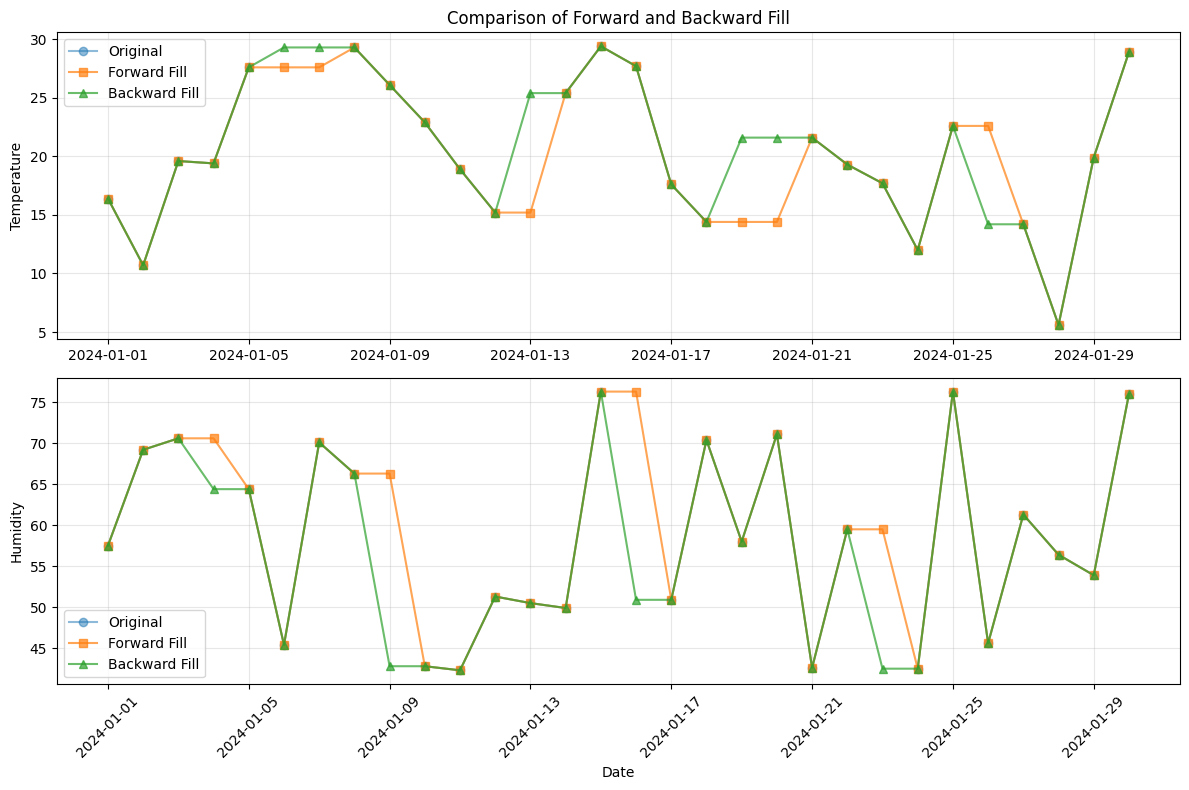

In [18]:
# Method 1: Forward and Backward Fill (for time series)
df_ts_ffill = df_timeseries.copy()
df_ts_bfill = df_timeseries.copy()

# Forward fill
df_ts_ffill['temperature'].fillna(method='ffill', inplace=True)
df_ts_ffill['humidity'].fillna(method='ffill', inplace=True)

# Backward fill
df_ts_bfill['temperature'].fillna(method='bfill', inplace=True)
df_ts_bfill['humidity'].fillna(method='bfill', inplace=True)

# Visualize the difference
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Temperature comparison
axes[0].plot(df_timeseries['date'], df_timeseries['temperature'], 'o-', label='Original', alpha=0.5)
axes[0].plot(df_ts_ffill['date'], df_ts_ffill['temperature'], 's-', label='Forward Fill', alpha=0.7)
axes[0].plot(df_ts_bfill['date'], df_ts_bfill['temperature'], '^-', label='Backward Fill', alpha=0.7)
axes[0].set_ylabel('Temperature')
axes[0].set_title('Comparison of Forward and Backward Fill')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Humidity comparison
axes[1].plot(df_timeseries['date'], df_timeseries['humidity'], 'o-', label='Original', alpha=0.5)
axes[1].plot(df_ts_ffill['date'], df_ts_ffill['humidity'], 's-', label='Forward Fill', alpha=0.7)
axes[1].plot(df_ts_bfill['date'], df_ts_bfill['humidity'], '^-', label='Backward Fill', alpha=0.7)
axes[1].set_ylabel('Humidity')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

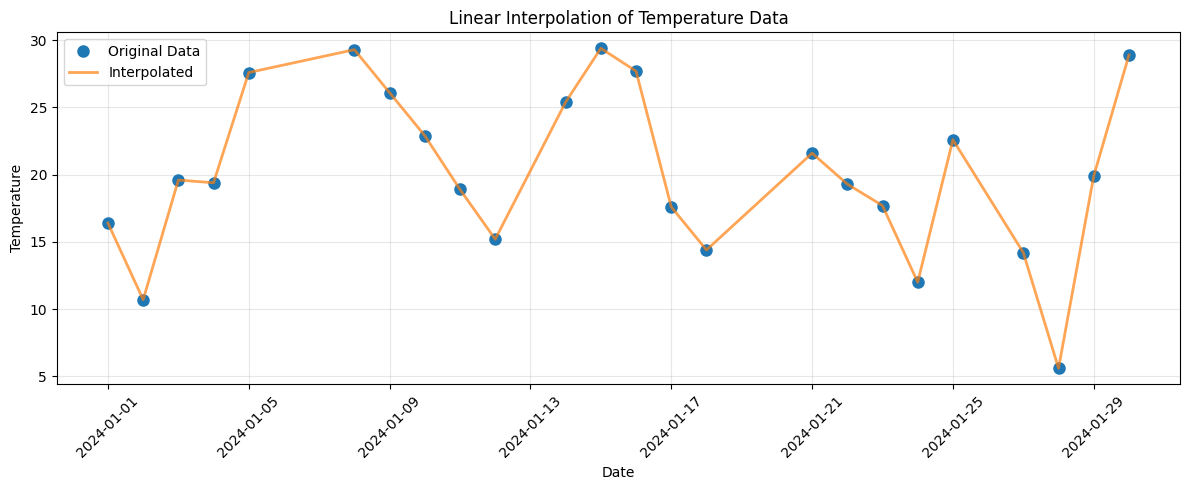

In [19]:
# Method 2: Interpolation (for time series or ordered data)
df_ts_interpolate = df_timeseries.copy()
df_ts_interpolate['temperature'] = df_ts_interpolate['temperature'].interpolate(method='linear')
df_ts_interpolate['humidity'] = df_ts_interpolate['humidity'].interpolate(method='polynomial', order=2)

# Visualize interpolation
plt.figure(figsize=(12, 5))
plt.plot(df_timeseries['date'], df_timeseries['temperature'], 'o', label='Original Data', markersize=8)
plt.plot(df_ts_interpolate['date'], df_ts_interpolate['temperature'], '-', label='Interpolated', alpha=0.7, linewidth=2)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Linear Interpolation of Temperature Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# Method 3: K-Nearest Neighbors (KNN) Imputation
from sklearn.impute import KNNImputer

# Prepare data (KNN needs numerical values only)
df_knn = df_sales[numerical_cols].copy()

# Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(
    knn_imputer.fit_transform(df_knn),
    columns=numerical_cols,
    index=df_knn.index
)

# Compare with simple mean imputation
comparison_df = pd.DataFrame({
    'Column': numerical_cols,
    'Original_Missing': df_knn.isnull().sum(),
    'Mean_Impute_Std': [df_mean_impute[col].std() for col in numerical_cols],
    'KNN_Impute_Std': [df_knn_imputed[col].std() for col in numerical_cols]
})

print("Comparison of imputation methods (Standard Deviation):")
print(comparison_df)

Comparison of imputation methods (Standard Deviation):
                                Column  Original_Missing  Mean_Impute_Std  \
units_sold                  units_sold                25        26.414526   
unit_price                  unit_price                31        25.819588   
customer_age              customer_age                 0        15.338066   
customer_income        customer_income                 7     20016.946176   
satisfaction_score  satisfaction_score                34         1.251795   

                    KNN_Impute_Std  
units_sold               26.753344  
unit_price               25.879791  
customer_age             15.338066  
customer_income       20089.561611  
satisfaction_score        1.257490  


In [21]:
# Method 4: Group-wise imputation
df_group_impute = df_sales.copy()

# Impute unit_price based on product_id groups
df_group_impute['unit_price'] = df_group_impute.groupby('product_id')['unit_price'].transform(
    lambda x: x.fillna(x.mean())
)

# Impute customer_income based on store_region
df_group_impute['customer_income'] = df_group_impute.groupby('store_region')['customer_income'].transform(
    lambda x: x.fillna(x.median())
)

print("Missing values after group-wise imputation:")
print(df_group_impute[['unit_price', 'customer_income']].isnull().sum())

Missing values after group-wise imputation:
unit_price         0
customer_income    0
dtype: int64


### Exercise 2: Custom Imputation Strategy
Create a function that imputes missing satisfaction scores based on whether the customer is a return customer.

In [22]:
def impute_satisfaction_by_return_status(df):
    """
    Impute missing satisfaction scores:
    - For return customers: use median of return customers
    - For non-return customers: use median of non-return customers
    """
    # Your code here
    pass

# Test your function
# df_custom = df_sales.copy()
# df_custom = impute_satisfaction_by_return_status(df_custom)
# print(f"Missing satisfaction scores: {df_custom['satisfaction_score'].isnull().sum()}")

## Section 5: Creating Missing Data Indicators

Sometimes the fact that data is missing is itself informative. We can create indicator variables to capture this.

In [23]:
# Create indicator variables for missing data
df_with_indicators = df_sales.copy()

# Create indicators for columns with missing values
for col in df_with_indicators.columns:
    if df_with_indicators[col].isnull().any():
        # Create indicator column
        indicator_col = f'{col}_was_missing'
        df_with_indicators[indicator_col] = df_with_indicators[col].isnull().astype(int)
        
        # Now impute the original column
        if col in numerical_cols:
            df_with_indicators[col].fillna(df_with_indicators[col].median(), inplace=True)
        else:
            df_with_indicators[col].fillna(df_with_indicators[col].mode()[0], inplace=True)

print("New columns created:")
indicator_cols = [col for col in df_with_indicators.columns if '_was_missing' in col]
print(indicator_cols)
print(f"\nDataset shape: {df_with_indicators.shape}")
df_with_indicators[indicator_cols].head()

New columns created:
['units_sold_was_missing', 'unit_price_was_missing', 'customer_income_was_missing', 'satisfaction_score_was_missing']

Dataset shape: (200, 12)


/var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/ipykernel_45242/2332751773.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_with_indicators[col].fillna(df_with_indicators[col].median(), inplace=True)
/var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/ipykernel_45242/2332751773.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

,units_sold_was_missing,unit_price_was_missing,customer_income_was_missing,satisfaction_score_was_missing
0,0,0,0,1
1,0,1,0,0
2,0,0,0,0
3,0,0,0,0
4,0,1,0,0


## Section 6: Evaluating Imputation Quality

Let's create a function to evaluate how well our imputation preserves the data distribution.

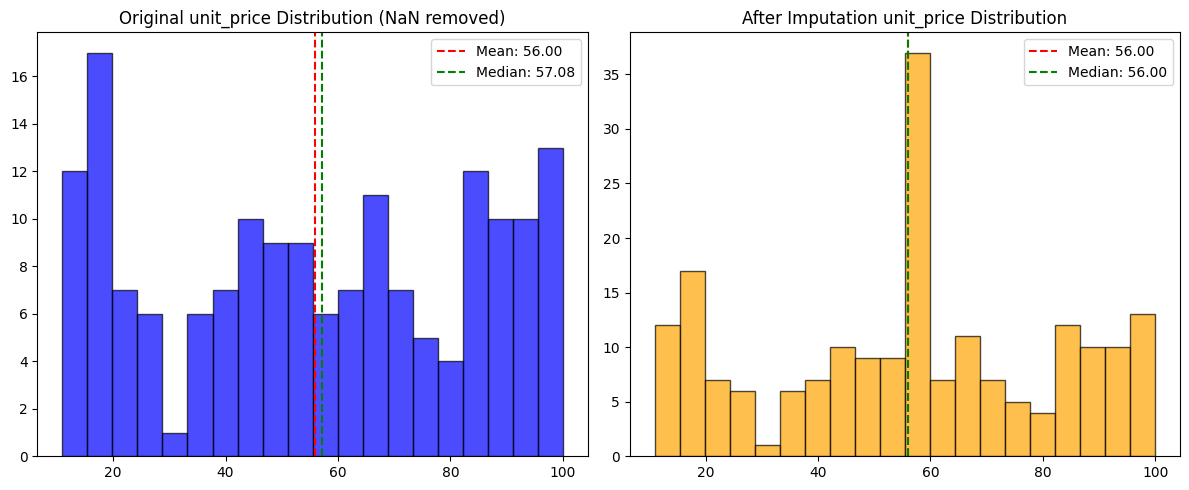


Statistics for unit_price:
Original - Mean: 56.00, Std: 28.10
Imputed  - Mean: 56.00, Std: 25.82
Difference in means: 0.00
Difference in std: 2.28


In [24]:
def compare_distributions(original_df, imputed_df, column):
    """Compare distributions before and after imputation"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original distribution (without NaN)
    original_clean = original_df[column].dropna()
    axes[0].hist(original_clean, bins=20, alpha=0.7, color='blue', edgecolor='black')
    axes[0].axvline(original_clean.mean(), color='red', linestyle='--', label=f'Mean: {original_clean.mean():.2f}')
    axes[0].axvline(original_clean.median(), color='green', linestyle='--', label=f'Median: {original_clean.median():.2f}')
    axes[0].set_title(f'Original {column} Distribution (NaN removed)')
    axes[0].legend()
    
    # Imputed distribution
    axes[1].hist(imputed_df[column], bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[1].axvline(imputed_df[column].mean(), color='red', linestyle='--', label=f'Mean: {imputed_df[column].mean():.2f}')
    axes[1].axvline(imputed_df[column].median(), color='green', linestyle='--', label=f'Median: {imputed_df[column].median():.2f}')
    axes[1].set_title(f'After Imputation {column} Distribution')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nStatistics for {column}:")
    print(f"Original - Mean: {original_clean.mean():.2f}, Std: {original_clean.std():.2f}")
    print(f"Imputed  - Mean: {imputed_df[column].mean():.2f}, Std: {imputed_df[column].std():.2f}")
    print(f"Difference in means: {abs(original_clean.mean() - imputed_df[column].mean()):.2f}")
    print(f"Difference in std: {abs(original_clean.std() - imputed_df[column].std()):.2f}")

# Compare different imputation methods
compare_distributions(df_sales, df_mean_impute, 'unit_price')

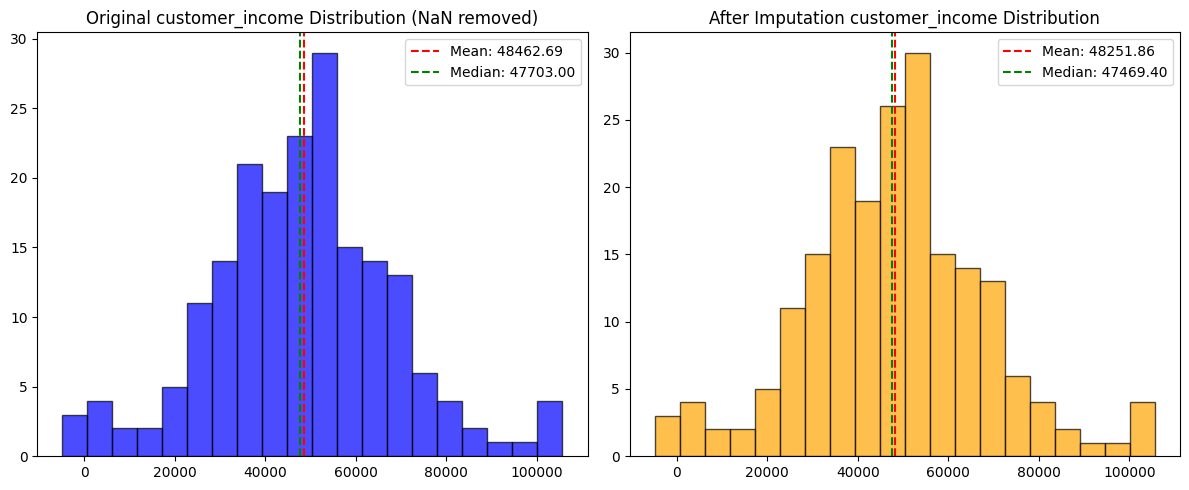


Statistics for customer_income:
Original - Mean: 48462.69, Std: 20378.57
Imputed  - Mean: 48251.86, Std: 20089.56
Difference in means: 210.83
Difference in std: 289.01


In [25]:
# Compare KNN imputation
compare_distributions(df_sales, df_knn_imputed, 'customer_income')

### Exercise 3: Complete Imputation Pipeline
Create a comprehensive function that handles all types of missing data in a dataset.

In [26]:
def complete_imputation_pipeline(df, method='mixed'):
    """
    Complete imputation pipeline:
    - method='mixed': Use appropriate method for each column type
    - method='simple': Use mean/mode for all columns
    - method='knn': Use KNN for numerical, mode for categorical
    
    Returns: imputed dataframe and a report of what was done
    """
    # Your code here
    pass

# Test your function
# df_final, report = complete_imputation_pipeline(df_sales.copy(), method='mixed')
# print(report)

## Summary and Best Practices

### Key Takeaways:

1. **Understand before acting**: Always analyze missing data patterns before choosing a strategy

2. **Deletion strategies**:
   - Use when missing data is minimal (<5%)
   - Good for MCAR (Missing Completely At Random)
   - Risk: Loss of information and statistical power

3. **Simple imputation**:
   - Mean/Median: Good for numerical data, quick and easy
   - Mode: Best for categorical data
   - Risk: Reduces variance, may introduce bias

4. **Advanced imputation**:
   - KNN: Preserves relationships between variables
   - Interpolation: Excellent for time series
   - Group-wise: Uses domain knowledge effectively

5. **Missing indicators**:
   - Preserve information about missingness
   - Useful when missingness is informative

### When to use each method:

- **Deletion**: Small amount of random missing data
- **Mean/Median**: Quick analysis, normally distributed data
- **Mode**: Categorical variables
- **Forward/Backward fill**: Time series with temporal patterns
- **Interpolation**: Smooth time series or ordered data
- **KNN**: When relationships between variables are important
- **Multiple Imputation**: For statistical inference and uncertainty quantification

Remember: No single method is perfect for all situations. The choice depends on:
- The mechanism of missingness (MCAR, MAR, MNAR)
- The amount of missing data
- The analysis goals
- Domain knowledge